# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
#!conda install -y -c conda-forge xgboost

In [2]:
from sklearn.base import BaseEstimator,MetaEstimatorMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [3]:
#for some statistics
from scipy import stats
from scipy.stats import norm, skew 
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

In [4]:
sns.set_style('whitegrid')
pd.options.display.max_rows = 100

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore')

# Data

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [7]:
train_Id = train['Id']
test_Id = test['Id']

# EDA

In [8]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

skewness: 1.883
kurotsis: 6.536


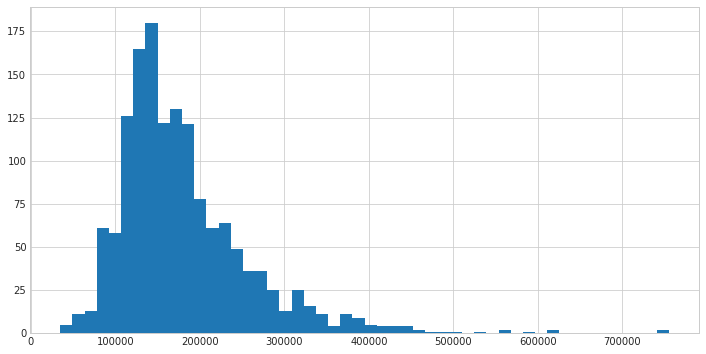

In [9]:
plt.figure(figsize=(12,6))
train['SalePrice'].hist(bins=50)
print('skewness: {:.3f}'.format(train['SalePrice'].skew()))
print('kurotsis: {:.3f}'.format(train['SalePrice'].kurt()))

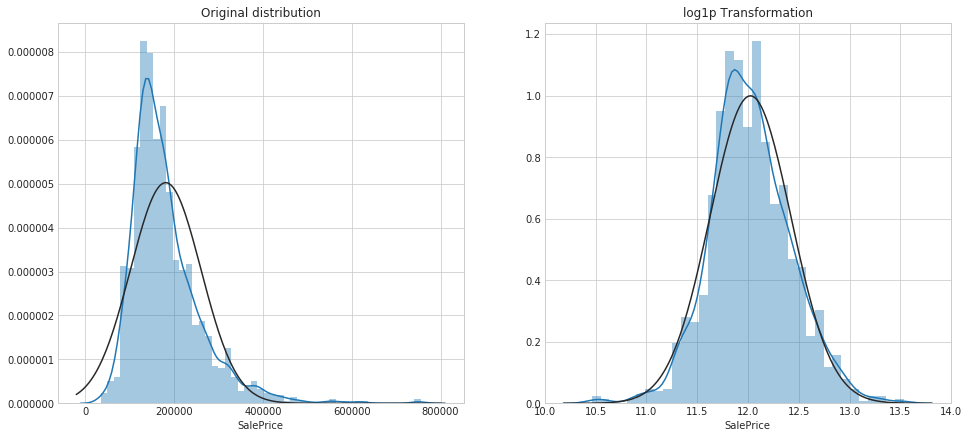

In [10]:
# target value dist,comapred with normal dist of target

# transforming target value to log(x), ML algs do well with normally distributed data

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(16,7))


sns.distplot(train['SalePrice'],fit=norm,ax=ax[0])
ax[0].set_title('Original distribution')


sns.distplot(np.log1p(train['SalePrice']),fit=norm,ax=ax[1])
ax[1].set_title('log1p Transformation')

plt.show()

# Data summary

In [11]:
df_summ = train.drop(['Id','SalePrice'],axis=1)

summary = pd.DataFrame({'dtype':df_summ.dtypes,'unique':df_summ.nunique(),
              'values':{ str(i):df_summ[i].value_counts().index.tolist() for i in df_summ.columns.tolist()},
             'null':df_summ.isnull().sum()}).sort_values(by='null',ascending=False)

In [12]:
## Understaing the data
summary.head()

,dtype,unique,values,null
PoolQC,object,3,"[Gd, Fa, Ex]",1453
MiscFeature,object,4,"[Shed, Gar2, Othr, TenC]",1406
Alley,object,2,"[Grvl, Pave]",1369
Fence,object,4,"[MnPrv, GdPrv, GdWo, MnWw]",1179
FireplaceQu,object,5,"[Gd, TA, Fa, Ex, Po]",690


In [13]:
catagorical_features = summary.loc[summary['dtype'] == 'object','dtype'].index.tolist()
numarical_features = summary.loc[summary['dtype'] != 'object','dtype'].index.tolist()

In [14]:
df = train.drop('Id',axis=1)

In [15]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Univariate Analysis

In [16]:
# lets start with YearBuilt,YearRemodAdd,YrSold
df[['YearBuilt','YearRemodAdd','YrSold']].head()

#print('\n')

#df[['YearBuilt','YearRemodAdd','YrSold']].isnull().any()

,YearBuilt,YearRemodAdd,YrSold
0,2003,2003,2008
1,1976,1976,2007
2,2001,2002,2008
3,1915,1970,2006
4,2000,2000,2008


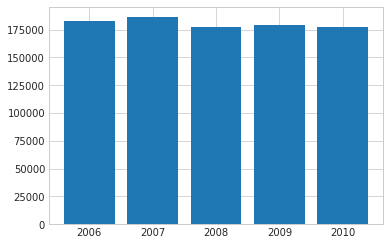

In [17]:
year_bar = df[['YrSold','SalePrice']].groupby('YrSold').mean()

plt.bar(year_bar.index.tolist(),height=year_bar['SalePrice']);

In [18]:
df[['YrSold','SalePrice']].corr()

,YrSold,SalePrice
YrSold,1.000000,-0.028923
SalePrice,-0.028923,1.000000


In [19]:
df[['YearBuilt','YearRemodAdd','YrSold','SalePrice']].corr()['SalePrice'].sort_values(ascending=False)

SalePrice       1.000000
YearBuilt       0.522897
YearRemodAdd    0.507101
YrSold         -0.028923
Name: SalePrice, dtype: float64

In [20]:
df['age'] = df['YrSold'] - df['YearBuilt'] 

df['age_re'] = df['YrSold'] - df['YearRemodAdd']


In [21]:
df[['age','age_re','SalePrice']].corr()['SalePrice']

age         -0.523350
age_re      -0.509079
SalePrice    1.000000
Name: SalePrice, dtype: float64

In [22]:
df['age_total'] = df['age'] - (df['age_re'] * 0.1)

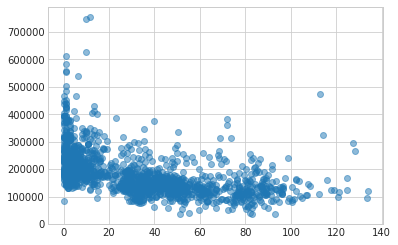

In [23]:
plt.scatter(df['age_total'],df['SalePrice'],alpha=0.5);

In [24]:
df[['age_total','SalePrice']].corr()

,age_total,SalePrice
age_total,1.000000,-0.508431
SalePrice,-0.508431,1.000000


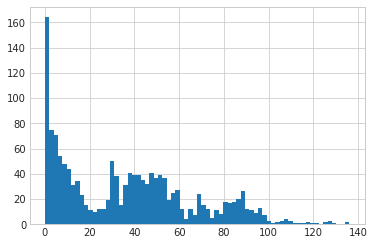

In [25]:
df['age'].hist(bins=70);

In [26]:
df[['MoSold','SalePrice']].corr()

,MoSold,SalePrice
MoSold,1.000000,0.046432
SalePrice,0.046432,1.000000


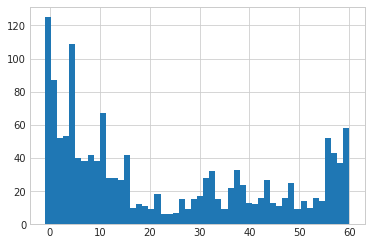

In [27]:
df['age_re'].hist(bins=50);

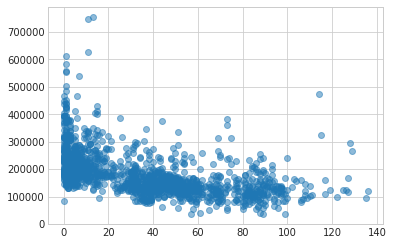

In [28]:
plt.scatter(df['age'],df['SalePrice'],alpha=0.5);

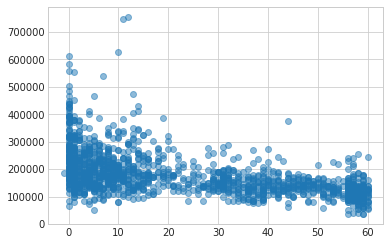

In [29]:
plt.scatter(df['age_re'],df['SalePrice'],alpha=0.5);

# Bivariate Analysis

In [30]:
df[numarical_features].isnull().sum() #LotFrontage GarageYrBlt MasVnrArea

LotFrontage      259
GarageYrBlt       81
MasVnrArea         8
MiscVal            0
MoSold             0
1stFlrSF           0
OpenPorchSF        0
MSSubClass         0
LowQualFinSF       0
OverallCond        0
YearRemodAdd       0
YearBuilt          0
WoodDeckSF         0
TotalBsmtSF        0
TotRmsAbvGrd       0
ScreenPorch        0
OverallQual        0
PoolArea           0
LotArea            0
HalfBath           0
3SsnPorch          0
BedroomAbvGr       0
BsmtFinSF1         0
BsmtFinSF2         0
BsmtFullBath       0
BsmtHalfBath       0
BsmtUnfSF          0
EnclosedPorch      0
Fireplaces         0
FullBath           0
GarageArea         0
GarageCars         0
GrLivArea          0
2ndFlrSF           0
KitchenAbvGr       0
YrSold             0
dtype: int64

In [31]:
df[['LotFrontage','GarageYrBlt','MasVnrArea','SalePrice']].corr()

,LotFrontage,GarageYrBlt,MasVnrArea,SalePrice
LotFrontage,1.000000,0.070250,0.193458,0.351799
GarageYrBlt,0.070250,1.000000,0.252691,0.486362
MasVnrArea,0.193458,0.252691,1.000000,0.477493
SalePrice,0.351799,0.486362,0.477493,1.000000


In [32]:
df[['LotFrontage','GarageYrBlt','MasVnrArea','SalePrice']].head()

,LotFrontage,GarageYrBlt,MasVnrArea,SalePrice
0,65.0,2003.0,196.0,208500
1,80.0,1976.0,0.0,181500
2,68.0,2001.0,162.0,223500
3,60.0,1998.0,0.0,140000
4,84.0,2000.0,350.0,250000


In [33]:
#['Id','GarageFinish','GarageQual','GarageType','GarageYrBlt','GarageCond']

df.loc[df['GarageYrBlt'].isnull(),['GarageFinish','GarageQual','GarageType','GarageYrBlt','GarageCond']].head()

,GarageFinish,GarageQual,GarageType,GarageYrBlt,GarageCond
39,NaN,NaN,NaN,NaN,NaN
48,NaN,NaN,NaN,NaN,NaN
78,NaN,NaN,NaN,NaN,NaN
88,NaN,NaN,NaN,NaN,NaN
89,NaN,NaN,NaN,NaN,NaN


In [34]:
df.loc[df['GarageYrBlt'].isnull(),['GarageYrBlt','YearBuilt','YearRemodAdd','SalePrice']].head()

,GarageYrBlt,YearBuilt,YearRemodAdd,SalePrice
39,NaN,1955,1955,82000
48,NaN,1920,2008,113000
78,NaN,1968,1968,136500
88,NaN,1915,1982,85000
89,NaN,1994,1995,123600


In [35]:
df['FireplaceQu'].value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [36]:
df_cat = df[catagorical_features]
df_cat['FireplaceQu'].value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

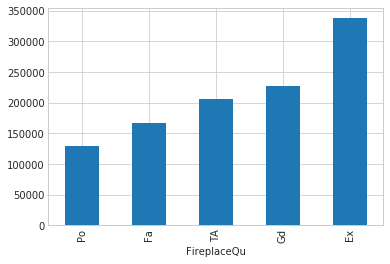

In [37]:
df_cat['SalePrice'] = train['SalePrice']
df_cat.groupby('FireplaceQu')['SalePrice'].mean().sort_values().plot(kind='bar');

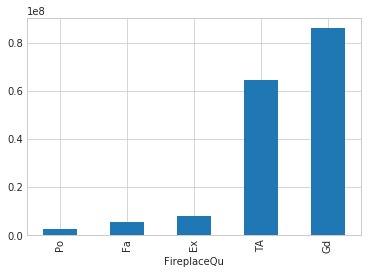

In [38]:
df_cat.groupby('FireplaceQu')['SalePrice'].sum().sort_values().plot(kind='bar');

In [39]:
df_cat.groupby('FireplaceQu')['SalePrice'].mean().sort_values()

FireplaceQu
Po    129764.150000
Fa    167298.484848
TA    205723.488818
Gd    226351.415789
Ex    337712.500000
Name: SalePrice, dtype: float64

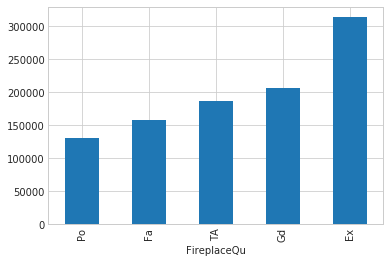

In [40]:
df_cat.groupby('FireplaceQu')['SalePrice'].median().sort_values().plot(kind='bar');

# Observation on categorical features:

* None values are not missing values, those are the facilities not available in the property
* We can not fill null values to 0, because those features are ordinal, we undermine the ordinality of the features when we encode these features into numbers.
* to find the ordinal relationship between classes in the features w.r.t Salespric, I used mean salse price within the classes in the feature and sort them in sequence and encoded them acc. to the sequence. 

# Observations on numerical features:

* Fill  the missing values with 0
* use mean for missing years 
* Month sold is not useful
* Skewed features need to transformed with boxcox1p transformation


# Multivariate Analysis

# Feature Engineering

In [41]:
## categorical features
## encoding all missing values to 'None' to a string, 
## to find the ordinal relationship between classes in the features w.r.t Salespric
## I used mean salse price within the classes in the feature and sort them in sequence and encoded them acc. to the sequence.

df_cat = df[catagorical_features]
df_cat['SalePrice'] = df['SalePrice']
df_cat.fillna('None',inplace=True)

cate_dict = {}

def catagorical_feat_dict(features,df_cat):
    
    for feat in features:

        df_features = df_cat[[feat,'SalePrice']].groupby(by = feat)['SalePrice'].mean().sort_values().index.tolist()
        
        #dict_feat = feat :{clas:df_features.index(clas) for clas in df_features}
        
        cate_dict.update({feat :{clas:df_features.index(clas) for clas in df_features}})
        
    return cate_dict

In [42]:
cata_dict = catagorical_feat_dict(catagorical_features,df_cat)

In [43]:
# Age,GarageAge

def year_transform(df):
    
    """ 
     Sorry this transformation dose nothing, I tryed diffrent methods but its not imporoving much, 
     I leftn it here for future updates on feature engineering. 
    """  
    df_num = df[numarical_features].fillna(value=0)

    df_num['Age'] = df_num['YearBuilt'] 
    
    df_num['AgeRemod'] = df_num['YearRemodAdd']

    df_num['GarageAge'] = df_num['GarageYrBlt']
    
    df_num.drop(['YrSold','YearBuilt','YearRemodAdd','GarageYrBlt'],axis=1,inplace=True)
    
    return df_num


In [44]:

df_num = year_transform(df)

In [45]:
#test_num = year_transform(train)

In [46]:
#df_num.loc[df_num['GarageAge'].isnull()]

In [47]:
#df_num.head().T

In [48]:
# gettng skewed features
skew_features = df_num.apply(lambda x: skew(x)).sort_values(ascending=False)

In [49]:

# using boxcox trasformation

def skew_transform(df_num):

    for fet in skew_features.index:
        
        if skew_features[fet] >0.70:
            try:
                df_num[fet] = boxcox1p(df_num[fet], boxcox_normmax(df_num[fet] + 1))
            except:
                print('error')

    return df_num


In [50]:
# skew transformajtions
df_num = skew_transform(df_num)

In [51]:
# skew trasformation
#test_num = skew_transform(test_num)

In [52]:
# change in skewness of the data
pd.DataFrame({'skew_before':skew_features,'skew_after':df_num.apply(lambda x: skew(x)).sort_values(ascending=False)}).sort_values(by='skew_before',ascending=False)

,skew_before,skew_after
MiscVal,24.451640,5.199813
PoolArea,14.813135,14.476284
LotArea,12.195142,-0.185294
3SsnPorch,10.293752,7.744137
LowQualFinSF,9.002080,7.392523
KitchenAbvGr,4.483784,3.953381
BsmtFinSF2,4.250888,2.645006
ScreenPorch,4.117977,3.328194
BsmtHalfBath,4.099186,3.925130
EnclosedPorch,3.086696,2.285796


In [53]:
def cata_transform(df,catagorical_features):
    
    df_cata = df[catagorical_features].fillna('None')
    
    for feat in catagorical_features:
        
        # map feature to encod values as in cat_dict
        df_cata[feat] = df_cata[feat].map(cata_dict[feat])
        
    return df_cata
    
    

In [54]:
df_cat.head()

,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,GarageCond,GarageFinish,GarageQual,GarageType,BsmtExposure,...,ExterQual,Exterior1st,Exterior2nd,Foundation,Functional,Heating,HeatingQC,HouseStyle,KitchenQual,SalePrice
0,None,None,None,None,None,TA,RFn,TA,Attchd,No,...,Gd,VinylSd,VinylSd,PConc,Typ,GasA,Ex,2Story,Gd,208500
1,None,None,None,None,TA,TA,RFn,TA,Attchd,Gd,...,TA,MetalSd,MetalSd,CBlock,Typ,GasA,Ex,1Story,TA,181500
2,None,None,None,None,TA,TA,RFn,TA,Attchd,Mn,...,Gd,VinylSd,VinylSd,PConc,Typ,GasA,Ex,2Story,Gd,223500
3,None,None,None,None,Gd,TA,Unf,TA,Detchd,No,...,TA,Wd Sdng,Wd Shng,BrkTil,Typ,GasA,Gd,2Story,Gd,140000
4,None,None,None,None,TA,TA,RFn,TA,Attchd,Av,...,Gd,VinylSd,VinylSd,PConc,Typ,GasA,Ex,2Story,Gd,250000


In [55]:
# catagorical data trasformatin (label encoding)
df_cat = cata_transform(df_cat,catagorical_features)

In [56]:

#test_cat = cata_transform(test,catagorical_features)

In [57]:

# merging numarical features and catagorical features
df_x = pd.concat([df_num,df_cat],axis=1)

In [58]:
## Adding new features

def add_new_features(df):
    
    df['TotalSF']=df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

    df['Total_sqr_footage'] = (df['BsmtFinSF1'] + df['BsmtFinSF2'] +
                                 df['1stFlrSF'] + df['2ndFlrSF'])

    df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                               df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))

    df['Total_porch_sf'] = (df['OpenPorchSF'] + df['3SsnPorch'] +
                              df['EnclosedPorch'] + df['ScreenPorch'] +
                              df['WoodDeckSF'])
    
    return df

In [59]:
# adding new additional features
df_x = add_new_features(df_x)

In [63]:
# transforming target value to log as requried on kaggle
y = np.log1p(train['SalePrice'])

df_new = df_x[['TotalSF','Total_sqr_footage','Total_Bathrooms','Total_porch_sf']]
df_new['SalePrice'] = y

In [64]:

## correlation between new features and Saleprice 
df_new[['TotalSF','Total_sqr_footage','Total_Bathrooms','Total_porch_sf','SalePrice']].corr()

,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,SalePrice
TotalSF,1.000000,0.990465,0.448451,0.216200,0.424689
Total_sqr_footage,0.990465,1.000000,0.429910,0.188791,0.363444
Total_Bathrooms,0.448451,0.429910,1.000000,0.364836,0.672885
Total_porch_sf,0.216200,0.188791,0.364836,1.000000,0.440537
SalePrice,0.424689,0.363444,0.672885,0.440537,1.000000


In [65]:
# transforming target value to log as requried on kaggle
#y = np.log1p(train['SalePrice'])

In [66]:
# train ans validation sets
X_train, X_val, y_train, y_val = train_test_split(df_x, y, test_size=0.20, random_state=42)

# Models

In [67]:
xgb_reg = xgb.XGBRegressor(max_depth=10,eta=0.1,subsample=0.7,n_estimators=250)

In [68]:
X_train.shape

(1168, 82)

# Training 

In [69]:
xgb_reg.fit(X_train,y_train, eval_set = [(X_train, y_train), (X_val, y_val)])

[12:51:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:10.3869	validation_1-rmse:10.3556
[1]	validation_0-rmse:9.35149	validation_1-rmse:9.32034
[2]	validation_0-rmse:8.42109	validation_1-rmse:8.39015
[3]	validation_0-rmse:7.58222	validation_1-rmse:7.55153
[4]	validation_0-rmse:6.82648	validation_1-rmse:6.79604
[5]	validation_0-rmse:6.14667	validation_1-rmse:6.11715
[6]	validation_0-rmse:5.53458	validation_1-rmse:5.5059
[7]	validation_0-rmse:4.98385	validation_1-rmse:4.9553
[8]	validation_0-rmse:4.48857	validation_1-rmse:4.46171
[9]	validation_0-rmse:4.04253	validation_1-rmse:4.0184
[10]	validation_0-rmse:3.64127	validation_1-rmse:3.61731
[11]	validation_0-rmse:3.27922	validation_1-rmse:3.25568
[12]	validation_0-rmse:2.9533	validation_1-rmse:2.93179
[13]	validation_0-rmse:2.66144	validation_1-rmse:2.63914
[14]	validation_0-rmse:2.39901

[137]	validation_0-rmse:0.006524	validation_1-rmse:0.138454
[138]	validation_0-rmse:0.006312	validation_1-rmse:0.138389
[139]	validation_0-rmse:0.006178	validation_1-rmse:0.138378
[140]	validation_0-rmse:0.006034	validation_1-rmse:0.138381
[141]	validation_0-rmse:0.005863	validation_1-rmse:0.138412
[142]	validation_0-rmse:0.005741	validation_1-rmse:0.138413
[143]	validation_0-rmse:0.00557	validation_1-rmse:0.138436
[144]	validation_0-rmse:0.00543	validation_1-rmse:0.138473
[145]	validation_0-rmse:0.00532	validation_1-rmse:0.138445
[146]	validation_0-rmse:0.005196	validation_1-rmse:0.138455
[147]	validation_0-rmse:0.0051	validation_1-rmse:0.138448
[148]	validation_0-rmse:0.004969	validation_1-rmse:0.138438
[149]	validation_0-rmse:0.004892	validation_1-rmse:0.138455
[150]	validation_0-rmse:0.004836	validation_1-rmse:0.138439
[151]	validation_0-rmse:0.004677	validation_1-rmse:0.138433
[152]	validation_0-rmse:0.0046	validation_1-rmse:0.138415
[153]	validation_0-rmse:0.004478	validation_1-r

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.7, verbosity=1)

# Predictions

In [70]:
y_prd = xgb_reg.predict(df_x)

In [71]:

# transforming predicted values to the orginal scal log1p - expm1
df_x['predict_count'] = np.expm1(y_prd)
df_x['count'] = np.expm1(y)

In [72]:
#numarical_features

In [73]:
# test data processing and predictions

# transforming years
test_num = year_transform(test.drop('Id',axis=1))

# transforming the skewed numarical features
test_num = skew_transform(test_num)

# Catagorical feature transformations
test_cat = cata_transform(test,catagorical_features)

# Adding new features 
test_x = add_new_features(pd.concat([test_num,test_cat],axis=1))


In [74]:

# test predictions
y_test_pred = xgb_reg.predict(test_x)

In [75]:

#transforming predicted values expm1 - log1p
test['predict_count'] = np.expm1(y_test_pred)

In [90]:
final_submission = pd.DataFrame({
        "Id": test["Id"],
        "SalePrice": test['predict_count']
    })
final_submission.to_csv("final_submission.csv", index=False)
final_submission.head()

,Id,SalePrice
0,1461,117917.242188
1,1462,126143.937500
2,1463,152174.656250
3,1464,164989.984375
4,1465,192705.468750


In [76]:
# predicdicted values stats
test['predict_count'].describe()

count      1459.000000
mean     148352.390625
std       45799.621094
min       59213.863281
25%      115811.035156
50%      133720.750000
75%      173193.250000
max      295861.062500
Name: predict_count, dtype: float64

# Train,Validation Error Plots


In [77]:
# evaluations
eval_result = xgb_reg.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

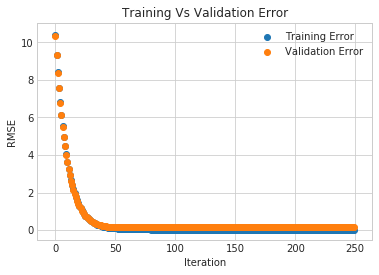

In [78]:
# plot traing and testing error

plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

In [81]:
# feature importance 

features_imp = pd.DataFrame({'feature':df_x.drop(['predict_count','count'],axis=1).columns,'importance':xgb_reg.feature_importances_})
#features_imp
                    

In [82]:
features_imp.sort_values(by='importance',ascending=False)[:10]

,feature,importance
40,GarageCond,0.140711
28,GarageCars,0.137757
65,CentralAir,0.078411
13,OverallQual,0.072056
77,KitchenQual,0.070710
46,BsmtQual,0.057291
41,GarageFinish,0.053358
29,GrLivArea,0.047349
80,Total_Bathrooms,0.042529
53,Neighborhood,0.031250


In [83]:
# Metric Use By Kaggle
def compute_rmsle(y_true, y_pred):
    if type(y_true) != np.ndarray:
        y_true = np.array(y_true)
        
    if type(y_pred) != np.ndarray:
        y_pred = np.array(y_pred)
     
    return(np.average((np.log1p(y_pred) - np.log1p(y_true))**2)**.5)

In [84]:
df_x['predict_count'].describe()

count      1460.000000
mean     180605.640625
std       77726.671875
min       34915.250000
25%      129357.220703
50%      163814.015625
75%      214032.460938
max      744619.437500
Name: predict_count, dtype: float64

In [85]:
compute_rmsle(df_x['predict_count'],df_x['count'])

0.06192769201463892

#  Residual Error distribution

In [86]:
residuals  = np.expm1(y) - np.expm1(y_prd)

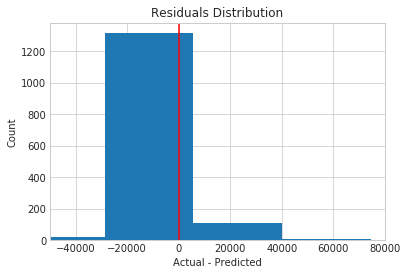

In [87]:
plt.hist(residuals)
plt.grid(True)
plt.xlabel('Actual - Predicted')
plt.xlim(-50000,80000)
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.axvline(color='r')
plt.show()

* our model overesting the target value

#  Save Model

In [ ]:
from sklearn.externals import joblib

In [ ]:
# save the model to disk
filename = 'finalized_xgb_reg.sav'
joblib.dump(xgb_reg, filename)

In [ ]:
## including predictions

df_x.to_csv('train_pred.csv')
test_x.to_csv('test_pred.csv')

